## Transformers : complething this ...

Author: *Krishaant Pathmanathan, PRAXIS UBC Team*

Date: 2025-06

___

In [20]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import plotly.graph_objects as go
import numpy as np
import seaborn as sns

## Prediction Game: Where Will the Ball Go?

Transformers are all about **making predictions from context**. But what does that really mean? Before diving into transformers, lets  start with something simple.

**Imagine this:**
You see a bouncing ball mid-air. Where will it go next? How do you know? You don’t need physics equations to guess. You use your intuition. You remember what came before — the ball’s past trajectory — and you predict what’s most likely to happen next.
Just like us, models try to guess what comes next based on what they've already seen. 

## Given an image of a ball can you predict where it will go next ?
<div style="display: flex; gap: 20px;">
  <img src="data/static_ball2.png" alt="Static ball" width="300"/>
  <img src="data/moving_ball3.png" alt="Moving ball" width="300"/>
</div>

Given a sequence, can you now tell ? This act of prediction based on prior observations is exactly what transformer models do with text, images, or sequences instead of balls. 

Turns out there are many sequences in the world - words in a sentence, frames in a video, notes in a melody, steps in a recipe. The challenge isn't just seeing them, it's predicting what comes next. To understand or predict them, we need a model that doesn’t just look at things in isolation…  It has to **remember what came before**.

<!-- maybe insert some pictures of that here  -->

## Sequential Prediction with RNNs

Imagine reading one word at a time, keeping track of what came before... that's what an RNN does. RNN stands for **Recurrent Neural Network**. It’s a type of model that learns from **sequences** — like sentences, music, or even time. It's an important precursor to a **transformer**

### How It Works (Step-by-Step)

1. **Give it a sentence** — for example:  
   `"I love recurrent neural ____"`

2. **Turn words into numbers** (this is called *tokenizing*)  
   > Computers can’t understand words — they only understand numbers!

3. **Send the numbers into the RNN** — one by one

4. **At each step**, the RNN tries to **remember what came before**  
   > It passes a little memory called a **hidden state** from word to word

5. **At the end**, it **guesses what comes next!**  
   > Like filling in the blank at the end of the sentence


In [30]:
# Simulated RNN function (takes a look at past to make prediction)

def my_rnn(word, hidden_state):
    # Imagine the RNN does something with the word and memory
    new_hidden_state = [h + 1 for h in hidden_state]  # update memory
    prediction = "networks!" if word == "neural" else None
    return prediction, new_hidden_state

# Initial hidden state
hidden_state = [0, 0, 0, 0]

# Input sentence (tokenized)
sentence = ["I", "love", "recurrent", "neural"]

# RNN step-by-step loop
for word in sentence:
    prediction, hidden_state = my_rnn(word, hidden_state)

# Final predicted word
next_word_prediction = prediction
print("Next word prediction:", next_word_prediction)


Next word prediction: networks!


###  Why RNNs Can Be Tricky ?

- They **read one word at a time**, so it’s slow
- They **forget things** after a while (just like people!)
- They **can’t look at everything at once**

RNNs are like someone reading a story **out loud, one word at a time**. Transformers (like GPT) are like someone **looking at the whole page at once**.

**RNNs walked, so Transformers could fly.**

## What is a GPT model ?

A GPT is a Generative Pre-Trained Transformer. The first two words are self-explanatory: generative means the model generates new text; pre-trained means the model was trained on large amounts of data. What we will focus on is the **transformer** aspect of the language model, the main proponent of the recent boom in AI.

## What's a transformer ?

A transformer is a neural network that learns context and thus meaning by tracking relationships in sequential data like the words in this sentence.It is the main component that underlies tools like ChatGPT. It can trained to take in a piece of text, maybe even with some surrounding images or sound accompanying it, then produce a prediction of what comes next, in the form of a probability distribution over all chunks of text that might follow.

*Note there are many other types of transformers (voice-to-text, text-to-image, etc.). 

## How does a transformer work ? 

**1) Embeddings A.K.A Turning Words into Numbers:** 

Before the model can understand anything it has to turn words into numbers. Not just any numbers, numbers that capture meaning. For instance the words "table" and "desk" might have numbers that are "simillar" (closer together in a vector space) whereas "table" and "apple" would be less simillar. Also, since the model doesn't intuitively understand the order of words like you and I we give it *positional encodings*. It's like telling the model this is the first, second, ... word in the sentence. 

,dim_0,dim_1,dim_2,dim_3,dim_4
he,1.643860,-0.100525,0.003647,1.286823,0.650395
deposited,0.876233,-0.749245,0.640592,-1.688277,-1.244219
cash,-0.639477,0.159270,-0.211871,0.027811,0.517446
at,0.427428,0.997778,0.221582,0.185604,-0.979497
the,0.851283,-1.261585,-1.227691,1.030984,0.357575
bank,-1.658985,-1.450936,-0.164531,-0.203644,-0.624906


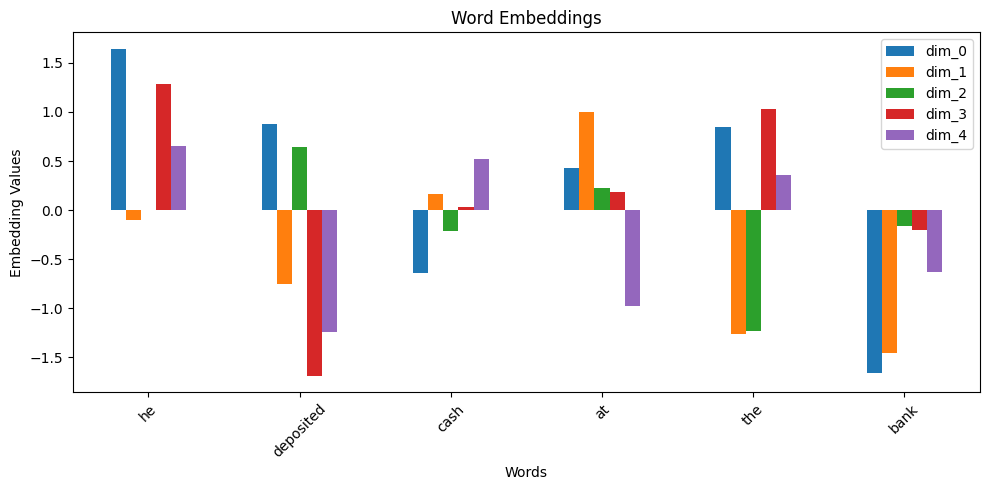

In [31]:
# Define a simple vocabulary
vocab = {
    'he': 0, 'deposited': 1, 'cash': 2, 'at': 3, 'the': 4, 'bank': 5,
    'on': 6, 'friday': 7, 'river': 8, 'runs': 9, 'fast': 10
}
vocab_size = len(vocab)
embedding_dim = 5  # keep it small so students can visualize

# Create the embedding layer
embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)

# Try editing this sentence! 
sentence = "he deposited cash at the bank"
tokens = sentence.lower().split()
token_ids = [vocab.get(word, 0) for word in tokens]  # default to 0 if word is missing

# Convert to tensor
input_tensor = torch.tensor(token_ids).unsqueeze(0)  # shape: [1, seq_len]

# Get vector representations
embedded = embedding(input_tensor).squeeze(0).detach()

# Display as a table
import pandas as pd
df = pd.DataFrame(embedded.numpy(), index=tokens, columns=[f"dim_{i}" for i in range(embedding_dim)])
display(df)

# Optional: Visualize with a bar chart for each word
df.plot(kind="bar", figsize=(10, 5), title="Word Embeddings")
plt.xlabel("Words")
plt.ylabel("Embedding Values")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Words that are more simillar like cash and bank, share some bars, whereas words that might represent grammar instead like "he" only has negative bars 

**2) Attention : Who's talking to Whom ?**

Imagine a dinner party conversation, You're trying to follow what someone is saying, but also who they are talking to, and who said what before that. Transformers to the same thing, they look at every word in a sentence and ask "which words should I pay most attention to in order to understand this word ?" This process is called attention, and it helps the model understand context - like knowing the difference between a river bank and a money bank. "He deposited cash at the bank on Friday."
The attention mechanism would allow the model to place more emphasis on the words "deposited", "cash", and "Friday", and less emphasis on function words like "the" — helping the model understand that "bank" refers to a financial institution, not a riverbank.

This idea of letting models decide what to pay "attention" to was first outlined in the landmark research paper “Attention is all you need” by Google in 2017

,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7
he,0.000000,1.000000,0.000000,1.000000,0.000000,1.00000,0.000,1.000000
deposited,0.841471,0.540302,0.099833,0.995004,0.010000,0.99995,0.001,1.000000
cash,0.909297,-0.416147,0.198669,0.980067,0.019999,0.99980,0.002,0.999998
at,0.141120,-0.989992,0.295520,0.955337,0.029995,0.99955,0.003,0.999996
the,-0.756802,-0.653644,0.389418,0.921061,0.039989,0.99920,0.004,0.999992
bank,-0.958924,0.283662,0.479426,0.877583,0.049979,0.99875,0.005,0.999988


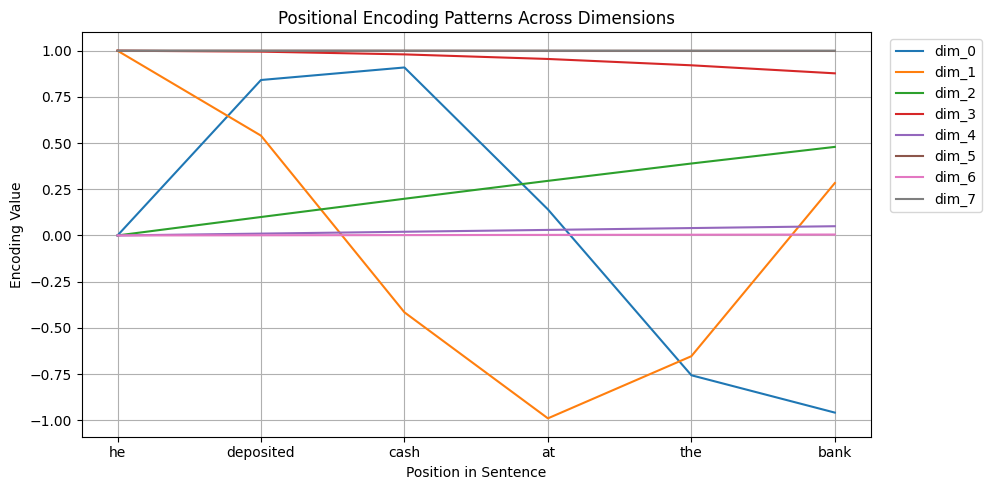

In [32]:
# Simulate a short sentence
tokens = ['he', 'deposited', 'cash', 'at', 'the', 'bank']
seq_len = len(tokens)
embedding_dim = 8  # Choose a small embedding size for demonstration

# === Step 1: Generate positional encodings
position = torch.arange(seq_len).unsqueeze(1)  # shape: [seq_len, 1]
div_term = torch.exp(torch.arange(0, embedding_dim, 2) * (-np.log(10000.0) / embedding_dim))

pe = torch.zeros(seq_len, embedding_dim)
pe[:, 0::2] = torch.sin(position * div_term)  # even indices
pe[:, 1::2] = torch.cos(position * div_term)  # odd indices

# === Step 2: Show in table
df = pd.DataFrame(pe.numpy(), index=tokens, columns=[f"dim_{i}" for i in range(embedding_dim)])
display(df)

# === Step 3: Visualize positional encodings
plt.figure(figsize=(10, 5))
for i in range(embedding_dim):
    plt.plot(pe[:, i], label=f"dim_{i}")
plt.title("Positional Encoding Patterns Across Dimensions")
plt.xlabel("Position in Sentence")
plt.ylabel("Encoding Value")
plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1.0))
plt.xticks(range(seq_len), tokens)
plt.grid(True)
plt.tight_layout()
plt.show()

Each coloured line helps the model tell the difference between words based on where they appear, through their encoding values. These patterns are carefully designed so that each position (1st word, 2nd word, 3rd word...) looks different to the model.

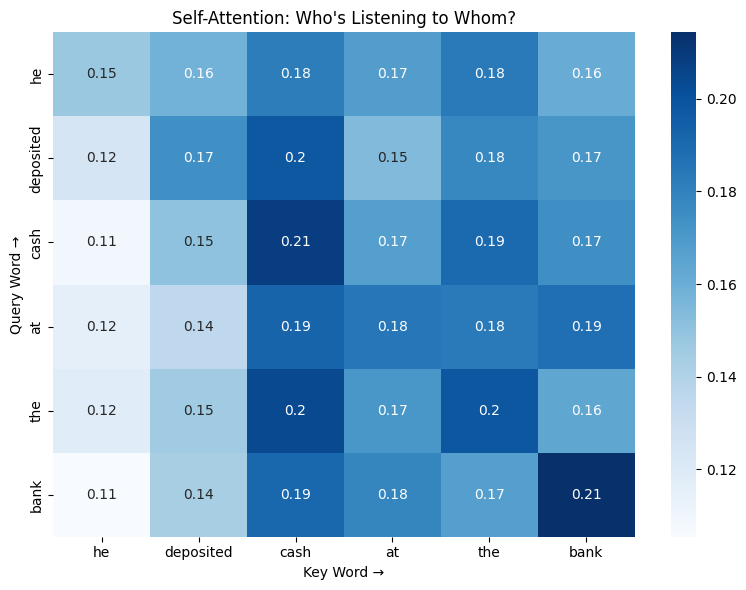

In [33]:
import torch
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Simple token list
tokens = ['he', 'deposited', 'cash', 'at', 'the', 'bank']
seq_len = len(tokens)
embed_dim = 4

# Simulate embeddings (normally from Step 1 + 2)
x = torch.rand(seq_len, embed_dim)  # [seq_len, embed_dim]

# Simulate attention: Q, K, V are all the same
Q = x
K = x
V = x

# Scaled dot-product attention
scores = torch.matmul(Q, K.T) / (embed_dim ** 0.5)  # [seq_len, seq_len]
attention_weights = F.softmax(scores, dim=-1)  # rows = which words each word attends to

# Display as heatmap
df = pd.DataFrame(attention_weights.numpy(), index=tokens, columns=tokens)
plt.figure(figsize=(8, 6))
sns.heatmap(df, annot=True, cmap="Blues")
plt.title("Self-Attention: Who's Listening to Whom?")
plt.ylabel("Query Word →")
plt.xlabel("Key Word →")
plt.tight_layout()
plt.show()


This maps shows who's paying attention to whom in this sentence. For example the word "cash" pays most attention to itself (0.24) but also listens to "he" (0.11). "he" looks around but leans toward “cash” and “bank”, possibly tracking who’s doing what. and 0The values here show how much attention is paid to each word, higher numbers = stronger focus. Rows add up to 1 because each word is spreading 100% of its attention across all other words in the sentence. Again this is important because, if the attention scores for “bank” were highest on “cash” or “deposited”, that would help the model guess that "bank" means money bank, not river bank.

**3) Thinking Layers (a.k.a. Feedforward Networks):** 

After deciding which words to pay "attention" to, the model passes each one through a thinking block (feed forward network) — basically a small decision-making system.It takes in a word’s current understanding and asks it a series of questions to refine its meaning. You can imagine it asking things like: “Is this word a noun? Does it seem important? What kind of word should come next?” Each of these layers updates the word’s internal representation based on what the model has learned from training.

Imagine the word “bank” in this sentence: "He deposited cash at the bank on Friday."

The model already knows — thanks to attention — that “cash” and “deposited” are important. Now the feed-forward layers take over and might internally ask:
“Does this word usually appear after the word cash?”, “Is this word often associated with financial transactions?”

Each question helps the model become more confident in its interpretation:

“Okay — this is probably a money bank, not a river bank.”

The model repeats this back-and-forth process:

Attention chooses what matters, Feed-forward layers analyze it

Then it loops again, with each layer getting a more refined picture of the sentence’s meaning

By the final layer, the model is ready to make a prediction — like guessing the next word, classifying a sentence, or answering a question. In text generation, this output takes the form of a probability distribution over all the words it knows.

<img src="data/transformerpredict.png" alt="Transformer Prediction" width="800"/>
<!-- if we decide to use this I will recreate this image with a more social science specific example  -->


,before_0,before_1,before_2,before_3,before_4,before_5,before_6,before_7,after_0,after_1,after_2,after_3,after_4,after_5,after_6,after_7
he,-0.129206,0.178290,0.657100,0.481666,0.309798,-2.152192,0.597497,0.368681,-0.080146,0.471731,-0.382218,0.030078,0.271282,-0.017408,-0.493094,-0.415424
deposited,0.515534,-0.356524,1.353467,-0.126288,-0.681467,-1.113580,-1.537067,1.236168,0.247645,0.314348,-0.285090,0.305878,0.306265,-0.097255,-0.109538,-0.349648
cash,1.656867,-0.787407,0.084012,-0.980995,-1.879004,-1.023641,-0.150441,-0.597256,-0.122747,-0.060938,-0.343645,-0.037165,0.132907,-0.165013,0.037248,-0.500071
at,-0.032183,0.324512,-1.421823,-1.827855,0.597699,-1.733485,-0.191748,-0.327176,0.013469,0.556255,-0.084791,-0.070419,0.104384,-0.164529,-0.184110,-0.493950
the,2.094588,-0.255707,1.279941,-0.987446,1.103475,0.049605,-0.161592,-0.671085,-0.226016,0.115639,-0.378568,0.081883,0.105097,-0.169929,0.079070,-0.470218
bank,1.287181,-0.747587,-1.418534,0.585491,1.312154,-2.178458,0.924003,-0.624614,-0.237976,0.577446,-0.170251,-0.027395,0.140302,0.003824,-0.362638,-0.475502


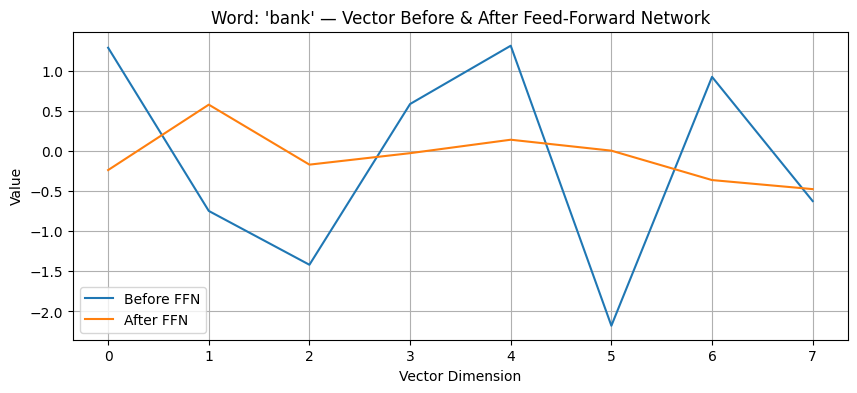

In [34]:
# Simulated output from attention (Step 3)
tokens = ['he', 'deposited', 'cash', 'at', 'the', 'bank']
attention_output = torch.randn(len(tokens), 8)  # 8-dim vectors per word

# Feed-Forward Network (same for all words)
ffn = nn.Sequential(
    nn.Linear(8, 16),  # Expand
    nn.ReLU(),
    nn.Linear(16, 8)   # Compress back
)
ffn_output = ffn(attention_output)

# Display before and after transformation
df_before = pd.DataFrame(attention_output.detach().numpy(), index=tokens, columns=[f"before_{i}" for i in range(8)])
df_after = pd.DataFrame(ffn_output.detach().numpy(), index=tokens, columns=[f"after_{i}" for i in range(8)])
df = pd.concat([df_before, df_after], axis=1)
display(df)

# Visualize how the vector for one word changes (e.g., "bank")
plt.figure(figsize=(10, 4))
plt.plot(df.loc['bank'].values[:8], label="Before FFN")
plt.plot(df.loc['bank'].values[8:], label="After FFN")
plt.title("Word: 'bank' — Vector Before & After Feed-Forward Network")
plt.xlabel("Vector Dimension")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

The orange line shows you that the feed forward network makes the word "bank" the output value for the word bank more smooth, making it more sure of what kind of work it is. 

**4) Unembedding matrix:** 

Once the model has chewed through the whole sentence, it takes all that processed information and makes a guess: “Based on everything I’ve seen so far, what word is most likely to come next?”

It does this by comparing its internal numbers to a giant list of all the words it knows, and picking the one with the highest score — kind of like autocomplete when texting, but way smarter.


**5) Weights, Weight Matrices, and Fine-tuning:**

**Weights:** Weights are parameters within a neural network that are
learned during the training process. They determine the strength and
direction of the connections in the network. Intially, weights
are set randomly; during training, the weights are adjusted to minimize
the error between the predicted output and the actual output, by
minimizing a loss function. This process is known as *gradient descent*.

**Weight matrices** are structured collections of weights arranged in
matrix form. They represent the connections between layers in a neural
network. The operation of passing inputs through the network involves
matrix multiplication: the input vector is multiplied by the weight
matrix to produce the output vector for the next layer.

In the attention mechanism, each word in the input sequence is
transformed into three different vectors: the query vector (used to
search for relevant information from other words in the sequence), the
key vector (represents the words in the sequence and is used to match
with query vectors), and the value vector (holds the actual information
of the words in the sequence and is used to generate the output of the
attention mechanism), using separate weight matrices $^{[14]}$. For
example, if the input is a sequence of words represented as vectors, the
queries, keys, and values are computed as:

$$Q=W_{Q}(X), K=W_{K}(X), V=W_{V}(X)$$

where $W_{Q}$​, $W_{K}$​, and $W_{V}$​ are weight matrices $^{[14]}$
$^{[15]}$. These vectors are used to calculate attention scores, which
determine how much focus each word should give to every other word in
the sequence.

**Fine-tuning** is the process of updating the key, query and value
matrices to reflect new data $^{[16]}$. Because the weight matrices
contain both the original, general weights and the new adjustments from
the fine-tuning process, fine-tuning allows the model to retain the
broad, general knowledge from the pre-training phase while specializing
in the a new task, such as sentiment analysis, customer feedback, etc.


## Transformer Applications 

Transformers aren't just for chatbots ! There are plenty of uses for transformers outside of this, espescially in the arts and humanities. For instance :
- Archival Text Restoration - filling in gaps in damaged ancient manuscripts 
- Symbol Classification - Automatically labelling ancient symbols and handwritting (eg. cuneiform tablets)
- Culutral Analysis - Using LLMs to trace narrative across historical text 



## Tokenization (this takes to long to load, might be too much, else I think including this would be good)

Just like text is broken into tokens, images are broken into patches, and audio is split into time steps or spectrogram slices before being passed to transformer models like ViT or Wav2Vec2.




In [35]:
from transformers import AutoTokenizer

# Load a BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Tokenize an example text
text = 'The ball is round.'
tokens = tokenizer(text)
tokens

{'input_ids': [101, 1996, 3608, 2003, 2461, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

## Word Prediction Demo

In [36]:
from transformers import pipeline

generator = pipeline('text-generation')
prompt = 'The history of the world is'
output = generator(prompt, max_length=20)
print(output[0]['generated_text'])

No model was supplied, defaulted to openai-community/gpt2 and revision 607a30d (https://huggingface.co/openai-community/gpt2).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The history of the world is complicated by the history of the earth. But it turns out that the


## References 

1. Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). Attention is All You Need. In Advances in Neural Information Processing Systems. arXiv:1706.03762

2. Brown, T. B., Mann, B., Ryder, N., Subbiah, M., Kaplan, J., Dhariwal, P., ... & Amodei, D. (2020). Language Models are Few-Shot Learners. arXiv:2005.14165

3. Vasvammi. Visual Explanation of Transformers.
https://vasvammi.github.io/transformer-visual

4. MIT Deep Learning: Introduction to Deep Learning (2024)
https://introtodeeplearning.com/2024/index.html

5. 3Blue1Brown: But What is a GPT?
https://www.3blue1brown.com/lessons/gpt

6. Henry AI Labs: Transformers in a Nutshell (YouTube)
https://www.youtube.com/watch?v=zxQyTK8quyY&vl=en

7. Peter Bloem: Transformers Explained Visually and Conceptually
https://peterbloem.nl/blog/transformers

8. Jay Alammar: The Illustrated Transformer
https://jalammar.github.io/illustrated-transformer/

9. COMET Docs: Fine-tuning LLMs with Ollama (UBC Arts)
https://comet.arts.ubc.ca/docs/4_Advanced/advanced_ollama_llm/fine_tuning_llm.html#setting-up

In [37]:
# Simplified code demo 

import torch
import torch.nn as nn
import torch.nn.functional as F

# === Step 1: Word Embeddings ===
vocab = {'he': 0, 'deposited': 1, 'cash': 2, 'at': 3, 'the': 4, 'bank': 5, 'on': 6, 'friday': 7}
tokens = ['he', 'deposited', 'cash', 'at', 'the', 'bank', 'on', 'friday']
token_ids = torch.tensor([vocab[word] for word in tokens]).unsqueeze(0)  # shape: [1, seq_len]

embedding_dim = 8
embedding = nn.Embedding(len(vocab), embedding_dim)
embedded_tokens = embedding(token_ids)

# === Step 2: Add Positional Encoding ===
pos = torch.arange(0, embedded_tokens.size(1)).unsqueeze(1).float()
div_term = torch.exp(torch.arange(0, embedding_dim, 2).float() * -(torch.log(torch.tensor(10000.0)) / embedding_dim))
pe = torch.zeros_like(embedded_tokens)
pe[:, :, 0::2] = torch.sin(pos * div_term)
pe[:, :, 1::2] = torch.cos(pos * div_term)
pos_embed = embedded_tokens + pe

# === Step 3: Self-Attention ===
Q = K = V = pos_embed
dk = Q.size(-1)
scores = torch.matmul(Q, K.transpose(-2, -1)) / dk**0.5
attention_weights = F.softmax(scores, dim=-1)
attention_output = torch.matmul(attention_weights, V)

# === Step 4: Feed-Forward Network ===
ffn = nn.Sequential(
    nn.Linear(embedding_dim, 32),
    nn.ReLU(),
    nn.Linear(32, embedding_dim)
)
ffn_output = ffn(attention_output)

# === Step 5: Unembedding and Final Output ===
unembedding = nn.Linear(embedding_dim, len(vocab))
logits = unembedding(ffn_output)
probs = F.softmax(logits, dim=-1)

# === Show Top Predictions for Each Token ===
for i, token in enumerate(tokens):
    pred_id = torch.argmax(probs[0, i]).item()
    pred_word = list(vocab.keys())[pred_id]
    print(f"{token} → Top prediction: {pred_word}")


he → Top prediction: at
deposited → Top prediction: he
cash → Top prediction: at
at → Top prediction: at
the → Top prediction: on
bank → Top prediction: at
on → Top prediction: at
friday → Top prediction: at
